# Data Exploration

Let's explore the data scrapped from [e-newspapersarchives.ch](https://www.e-newspaperarchives.ch/?a=p&p=home&e=-------fr-20--1--txt-txIN-+e-------0--fr---).

Quick reminder before starting: `articles.csv` contains all articles found on the aforementionned website that contain the world "écologie" (accent sensitive). The file contains several informations about the retrieved articles:
- *Article Title*: the header of the article
- *Journal*: name of the newspaper in which it was published
- *Date*: date of publication (in french, format: DAY mois YEAR, eg. 10 septembre 1992)
- *Url*: url link to the article
- *Text*: OCR text from the article

In [1]:
# import basic packages
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# import package to parse date from str to datetime format
try:
    import dateparser
except:
    !pip install dateparser
    import dateparser

In [3]:
# import packages for some additional scrapping
import requests
from bs4 import BeautifulSoup

# make our scraper look like a legitimate browser
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

## Preliminary

Load the dataset and clean it from NaNs.

In [4]:
# load the dataset into a Pandas DataFrame and parse the date
articles = pd.read_csv("./Data/all_articles.csv", parse_dates=['Date'], date_parser=dateparser.parse)
n_before = len(articles) # number of articles in the DF
# print 5 radom rows
articles.sample(5)

,Unnamed: 0,Unnamed: 0.1,Article Title,Journal,Date,Url,Text,Unnamed: 0.1.1
20875,9197,197,Quel avenir pour l'agriculture?,La Gazette,1990-06-21,https://www.e-newspaperarchives.ch/?a=d&d=GDM1...,Quel avenir pour lagriculture ? La politique...,17.0
16630,4952,952,80 mètres dans le précipice J,Le Nouvelliste,1982-08-21,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,80 mètres dans le précipice J SIERRE ( bd ) ...,12.0
21660,9982,982,12 Lfl LIBERTE LUNDI 12 NOVEMBRE 2001,La Liberté,2001-11-12,https://www.e-newspaperarchives.ch/?a=d&d=LLE2...,12 Lfl LIBERTE LUNDI 12 NOVEMBRE 2001 -ils u...,2.0
19903,8225,225,EEE Les salariés et les employeurs n'ont...,La Liberté,1992-11-05,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,EEE Les salariés et les employeurs nont pas l...,5.0
20343,8665,665,Avec les gymnastes de Charmey. Souriante vital...,La Gruyère,1979-05-17,https://www.e-newspaperarchives.ch/?a=d&d=LGE1...,Avec les gymnastes de Charmey Souriante vita...,5.0


In [5]:
# drop rows (=articles) with missing informations
articles = articles.dropna().reset_index()
print("{0} rows with NaN dropped, {1} articles remaining in the DF.".format(n_before-len(articles), len(articles)))

3717 rows with NaN dropped, 18961 articles remaining in the DF.


In [6]:
# drop duplicate rows
articles = articles.drop_duplicates(subset=['Text'])
print("{0} rows remaining in the dataset after dropping duplicates.".format(len(articles)))

18919 rows remaining in the dataset after dropping duplicates.


## Distribution over time

Let's first look at the number of articles retrieved per year. After a coarse analysis of the retrieved articles containing the world 'écologie', we will compare it with the content of the whole database of newspaper articles in french from the website.

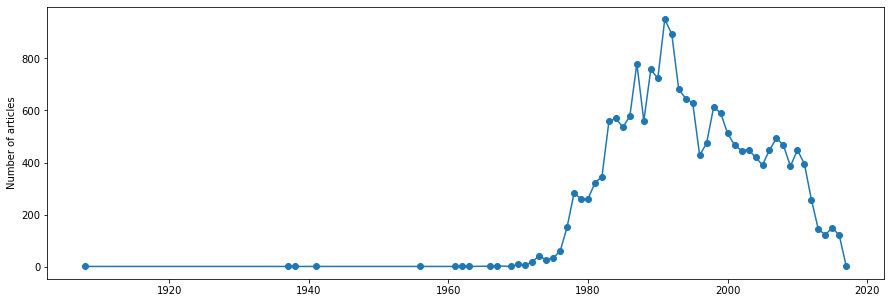

In [7]:
# number of articles per year
articles_per_year = articles.groupby(articles.Date.dt.year).count().Url

# plot the timeserie
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles_per_year)
ax.scatter(articles_per_year.index, articles_per_year.values)

plt.ylabel('Number of articles')

plt.show()

From the above plot, one can already see that this term began to be used in the late 60s/early 70s and peaked around 1990 and a second, less important, peak happened around 2010.

In [8]:
print("The year with the most articles containing 'écologie' is {0}, with {1} articles.\
".format(articles_per_year.keys()[articles_per_year == np.max(articles_per_year)][0], np.max(articles_per_year)))

The year with the most articles containing 'écologie' is 1991, with 950 articles.


In [9]:
print("Only {0} articles were found before 1970.".format(len(articles[articles.Date.dt.year<1970])))

Only 15 articles were found before 1970.


Grouping the articles by decade

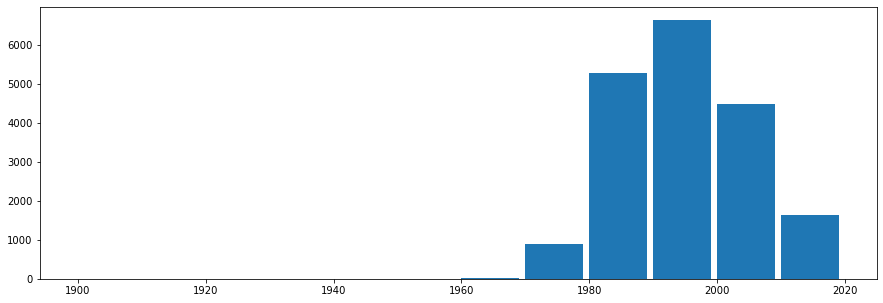

In [10]:
articles_per_decade = articles.groupby((articles.Date.dt.year//10)*10).count().Url

plt.figure(figsize=(15,5))
plt.bar(articles_per_decade.index
        , articles_per_decade
        , width=9
        , align='edge'
       )
plt.show()

Such a grouping makes the 2010's peak disappear as it was centered around 2010 (from late 2000s to early 2010s).

More than an absolute count of the number of articles containing the word 'écologie', it is important to assess its relative importance compared with the total number of articles present in the database of the scrapped website in order to check if the peaks are not "artificial" as they could just be reflecting years with more articles in the database. 

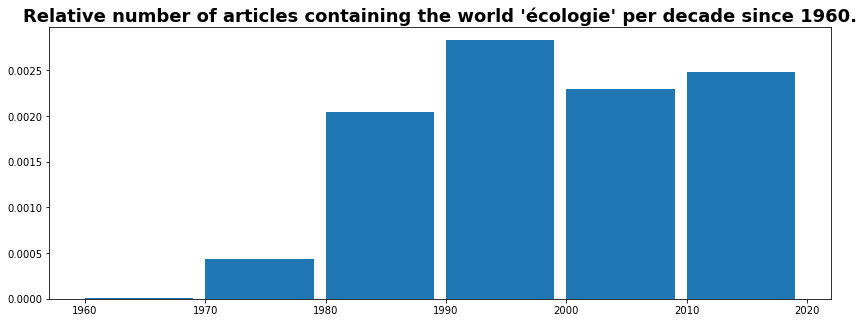

In [11]:
# total number of french articles on e-newspaperarchives.ch manually scrapped from 1960s to 2010s
tot_articles_per_decade = np.array([2138059, 2023171, 2580757, 2340471, 1948820, 660912])
rel_articles_per_decade_60 = articles_per_decade[articles_per_decade.keys() > 1955]/tot_articles_per_decade

plt.figure(figsize=(14,5))
plt.bar(rel_articles_per_decade_60.index
        , rel_articles_per_decade_60
        , width=9
        , align='edge'
       )

plt.title(
    "Relative number of articles containing the world 'écologie' per decade since 1960."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

In [12]:
# if file already stored, load it, else scrap data
try:
    tot_n_articles = np.load("tot_n_articles.pkl", allow_pickle=True)
except:
    # initialization 
    years = range(1960, 2017)
    tot_n_articles = pd.Series(index=years, dtype=int)
    # retrieving the total number of articles (in french) per year based on the search of articles containing: ' '
    for y in years:
        url_curr = "https://www.e-newspaperarchives.ch/?a=q&hs=1&r=1&results=1&txq=%27+%27&dafdq=&dafmq=&dafyq="+str(y)+"&datdq=&datmq=&datyq="+str(y)+"&laq=fr&puq=&txf=txIN&ssnip=img&ccq=&e=-------fr-20--1--img-txIN-%27+%27-ARTICLE------0--fr---"

        req = requests.get(url_curr, headers)
        soup = BeautifulSoup(req.content, 'html.parser')
        header = soup.find_all("title")[0].text.replace("— e-newspaperarchives.ch", "") # eg. Résultats 1 - 20 de  186,326 pour ' '

        tot_n_articles[y] = np.int(header[21:28].replace(",","")) # convert the number of found articles from str to int

    # save it to a pickle file
    tot_n_articles.to_pickle("tot_n_articles.pkl")

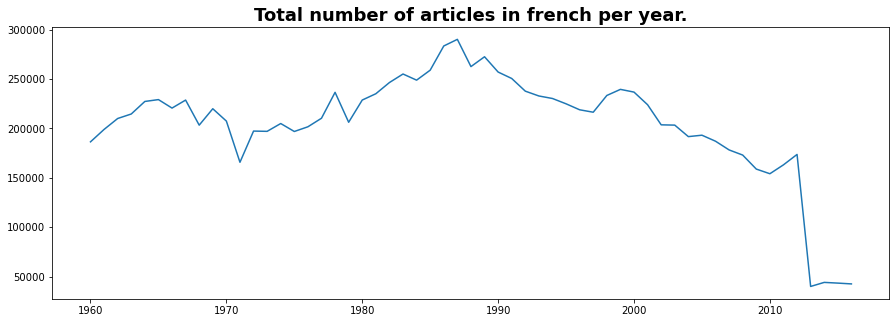

In [13]:
# plot the number of articles per year on the database:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(tot_n_articles)

plt.title(
    "Total number of articles in french per year."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

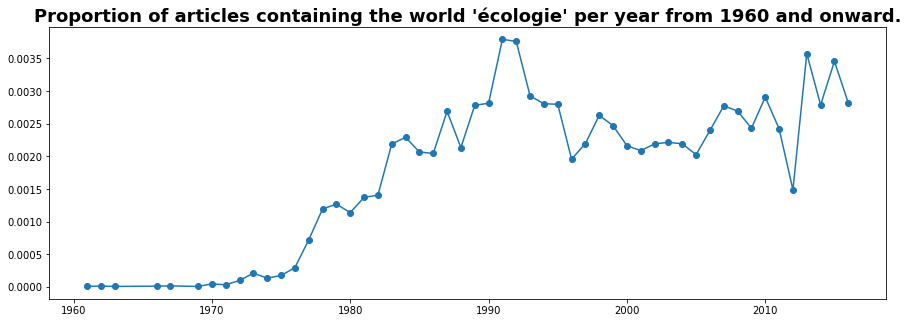

In [14]:
rel_eco_year = (articles_per_year[articles_per_year.index>1959]/tot_n_articles).dropna()

# plot the timeserie of relative number of articles per year
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(rel_eco_year)
ax.scatter(rel_eco_year.index, rel_eco_year.values)

plt.title(
    "Proportion of articles containing the world 'écologie' per year from 1960 and onward."
    , weight='semibold'
    , fontsize = 18
)

plt.show()

++ we can see a strange pattern by month (if significant?)

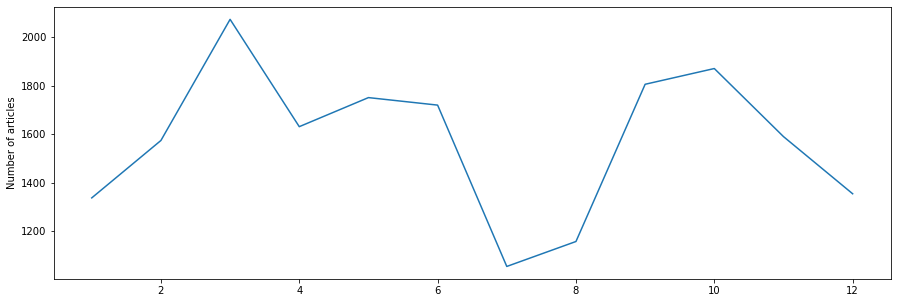

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles.groupby(articles.Date.dt.month).count().Url)

plt.ylabel('Number of articles')

plt.show()

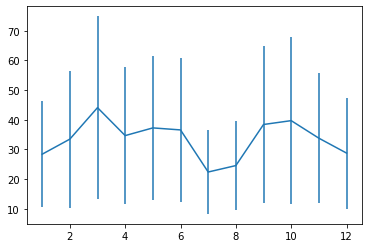

In [16]:
y_m_articles = articles[articles.Date.dt.year>1970].groupby([articles.Date.dt.year, articles.Date.dt.month]).count().Url
y_m_articles.index.set_names(["Year", "Month"], inplace=True)
mean_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').mean()[0]
std_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').std()[0]

plt.errorbar(mean_m_articles.index, mean_m_articles, yerr=std_m_articles)
plt.show()
# seems not really significant all in all

## Distribution over newspaper editors

Let's then study the diversity of the corpus in term of the distribution of the articles over different newspaper editors.

As we did for the evolution along time, the statistics found for the retrieved corpus will also be compared to the general tendencies of the whole database.

In [17]:
n_journaux = articles.groupby(articles.Journal).count().Url.sort_values()
print("The dataset contains articles from {0} editors.".format(len(n_journaux)))

The dataset contains articles from 26 editors.


Let's have a look at the number of articles per editor:

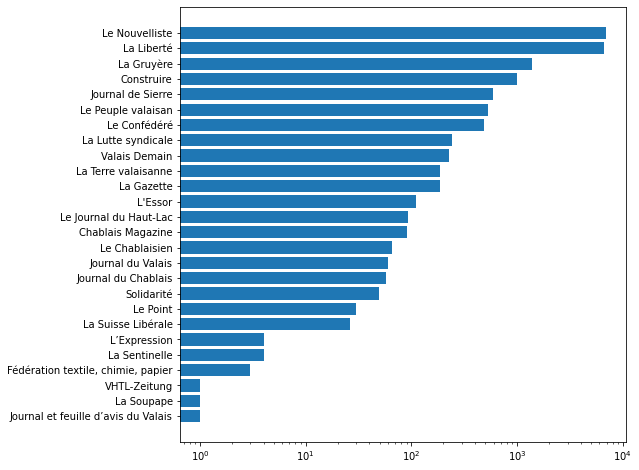

In [18]:
plt.figure(figsize=(8,8))
plt.barh(n_journaux.keys(), n_journaux)
plt.semilogx()
plt.show()

One can see from the above plot that the dataset is largely dominated by two editors, namely *Le Nouvelliste* and *La Liberté*.

In [19]:
print("The two most represented editors have published {0:.2f}% of all the articles present in the dataset.\
".format(100*(n_journaux[-1]+n_journaux[-2])/n_journaux.sum()))

The two most represented editors have published 71.34% of all the articles present in the dataset.


We can also look at the political repartition of the newspapers. We manually research the political orientation of the newspapers.

In [20]:
orientation_journaux = {
    "Journal et feuille d’avis du Valais" : "right",
    "La Soupape": "neutral",
    "VHTL-Zeitung": "left",
    "Fédération textile, chimie, papier": "left",
    "La Sentinelle": "left",
    "L’Expression": "right",
    "La Suisse Libérale": "right",
    "Le Point": "right",
    "Solidarité": "left",
    "Journal du Chablais": "neutral",
    "Journal du Valais": "right",
    "Le Chablaisien": "neutral",
    "Chablais Magazine": "neutral",
    "Le Journal du Haut-Lac": "neutral",
    "L'Essor": "left",
    "La Gazette": "neutral",
    "La Terre valaisanne": "left",
    "Valais Demain" : "right",
    "La Lutte syndicale" : "left",
    "Le Confédéré" : "left",
    "Le Peuple valaisan" : "left",
    "Journal de Sierre" : "neutral",
    "Construire" : "neutral",
    "La Gruyère" : "left",
    "La Liberté" : "right",
    "Le Nouvelliste" : "right"
}

In [33]:
articles_w_or = articles.copy()
articles_w_or['orientation'] = articles.apply(lambda row : orientation_journaux[row['Journal']], axis=1)

In [34]:
or_articles = articles_w_or.groupby('orientation')['Url'].count()
or_articles

orientation
left        2986
neutral     2087
right      13846
Name: Url, dtype: int64

In [35]:
print("The dataset contains articles {0}% of right-winged articles, {1}% of left-winged ones, and {2}% of neutral ones.".format(or_articles['right']/or_articles.sum()*100,or_articles['left']/or_articles.sum()*100, or_articles['neutral']/or_articles.sum()*100))

The dataset contains articles 73.1856863470585% of right-winged articles, 15.783075215391934% of left-winged ones, and 11.031238437549554% of neutral ones.


We now scrap the total number of articles in the database coming from the different editors in order to see if some write relatively more about 'écologie' or if it is more or less proportionnal to the total number of articles from the editor present in the database. In other word, we will try to see if we found more articles stating 'écologie' for *Le Nouvelliste* and *La Liberté* because it is a word that they use more than other publishers or just because there are more articles from these editors in [e-newspaperarchives.ch](https://www.e-newspaperarchives.ch/?l=fr) or if it is truly relatively more used than in other newspapers.

In [ ]:
# if file already stored, load it, else scrap data
try:
    series_journal = np.load("series_journal.pkl", allow_pickle=True)
except:
    # from 1970 and onward
    url_tot = "https://www.e-newspaperarchives.ch/?a=q&hs=1&r=1&results=1&txq=%27+%27&dafdq=&dafmq=&dafyq=1970&datdq=&datmq=&datyq=&laq=fr&puq=&txf=txIN&ssnip=img&ccq=&e=-------fr-20--1--img-txIN-%27+%27-ARTICLE------0--fr---"
    req = requests.get(url_tot, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    # retrieve information from the html soup, store in list
    list_journal = [tag.text for tag 
                    in soup.find("div", {"id": "facet-PU"}).find_all("div", {"class": "searchresultfacetentry"})]
    # transform list in Pandas Series
    series_journal = pd.Series([int(s.split("(")[1].split(")")[0].replace(",","")) for s in list_journal]
                           , index=[s.split("(")[0] for s in list_journal]
                           , dtype=int
                          )
    # save it to a pickle file
    series_journal.to_pickle("series_journal.pkl")
    
series_journal[:5]

In [ ]:
# proportion of articles stating 'écologie' for each editor
rel_eco_articles = (n_journaux/series_journal).dropna().sort_values()

In [ ]:
data_x = rel_eco_articles.index
data_hight = rel_eco_articles.values
data_color = [(np.log(n_journaux[j])-np.log(n_journaux.min()))/(np.log(n_journaux.max())-np.log(n_journaux.min()))
              for j in rel_eco_articles.keys()]


data_color = [x / max(data_color) for x in data_color]
fig, ax = plt.subplots(figsize=(14, 10))

my_cmap = plt.cm.get_cmap('RdBu')
colors = my_cmap(data_color)
rects = ax.barh(data_x, data_hight, color=colors)

sm = cmap.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label("Relative number of articles in the corpus", rotation=270,labelpad=25)

plt.yticks(data_x)    
plt.xlabel("Proportion of articles containing 'écologie' per editor")

plt.show()

## Editors' time

Let's put both of the precedently studied features together now by exporing the evolution of the presence of the editors. As seen before, two editors are much more in the dataset, we will then rearrange the DF for this part of the exploration. Instead of the name of the newspaper, all articles that are not published in one of the two top editors will appear has published in *Others*.

In [ ]:
top_editors = np.array(n_journaux.keys()[-2:])
articles_top_others = articles.copy()
articles_top_others["Journal"] = [j if j in top_editors else "Others" for j in articles_top_others["Journal"]]

In [ ]:
# number of articles per journal per year
evol_year_top_others = articles_top_others[articles_top_others.Date.dt.year>1960].groupby([articles_top_others.Date.dt.year, "Journal"]).count().Url.unstack().fillna(0)
# normalization over the year (for each year --> sum to 1)
evol_year_top_others_norm = evol_year_top_others.div(evol_year_top_others.sum(axis=1), axis=0)

In [ ]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others.plot.area(ax=axis)
plt.show()

In [ ]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others_norm.plot.area(ax=axis)
plt.show()

The same analysis can be lead on decades:

In [ ]:
decade_top_others = articles_top_others[(articles_top_others.Date.dt.year//10)*10 >1955].groupby([(articles_top_others.Date.dt.year//10)*10, "Journal"]).count().Url.unstack().fillna(0)
decade_top_others

In [ ]:
fig, axis = plt.subplots(figsize=(15,7))
decade_top_others.plot.bar(stacked=True, align='edge', ax=axis, width=0.9)
plt.show()